# Homework 2 (WIP)

* Implement an explicit Runge-Kutta integrator that takes an initial time step $h_0$ and an error tolerance $\epsilon$.
* You can use the Bogacki-Shampine method or any other method with an embedded error estimate.
* A step should be rejected if the local truncation error exceeds the tolerance.
* Test your method on the nonlinear equation
$$ \begin{bmatrix} \dot u_0 \\ \dot u_1 \end{bmatrix} = \begin{bmatrix} u_1 \\ k (1-u_0^2) u_1 - u_0 \end{bmatrix} $$
for $k=2$, $k=5$, and $k=20$.
* Make a work-precision diagram for your adaptive method and for constant step sizes.

In [1]:
%precision 3
%matplotlib notebook

import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

## Runge-Kutta Implementation

A work-in-progress adaptation of code from the lectures.

Incidentally, according to the internet, the test equation is the Van der Pol Equation:

$$x'' - k(1 - x^2)x' + x = 0$$

<IPython.core.display.Javascript object>


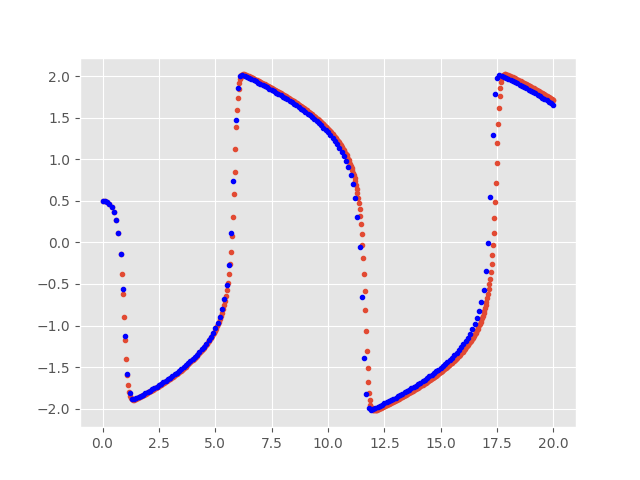

In [22]:
class hw_eqn:
    def __init__(self, k):
        self.k = k
    def f(self, t, u):
        return numpy.array([u[1], self.k * (1 - u[0] ** 2) * u[1] - u[0]])

def rk_butcher_4():
    '''
    Provides Butcher Table values for RK4.
    '''
    A = numpy.array([[0,0,0,0],[.5,0,0,0],[0,.5,0,0],[0,0,1,0]])
    b = numpy.array([1/6, 1/3, 1/3, 1/6])
    return A, b

def rk_butcher_bs3():
    '''
    Provides Butcher Table values for Bogacki–Shampine method.
    '''
    A = numpy.array([
        [0, 0, 0, 0], 
        [1/2, 0, 0, 0], 
        [0, 3/4, 0, 0], 
        [2/9, 1/3, 4/9, 0]])
    
    # b has two rows, (1) the one we'll propogate and (2) the error estimator
    # There are four stages, with 3rd-order accuracy from the propogated result.
    b = numpy.array([
        [2/9, 1/3, 4/9, 0], 
        [7/24, 1/4, 1/3, 1/8]])
    
    return A, b


def ode_rkexplicit(f, u0, tfinal=1, h=.1, eps=0.01, adaptive=True):
    '''
    f: RHS function of the equation u' = f(t, u)
    u0: initial guess for u, an nx1 array
    tfinal: final time value
    h: initial time step size (default: 0.1)
    eps: error tolerance
    '''
    A, b = rk_butcher_bs3()

    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    hist = [(t,u0,0)]
    safetyFactor = 0.9
    rkMethodOrder = 3

    while t < tfinal:
        # Prepare the next time value
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h

        # Ensure that we don't step beyond the allowed time interval
        h = min(h, tfinal - t)
        
        # Evaluate the stages sequentially
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        
        # Since fY is organized in columns, we can post-multiply by b to 
        # calculate b^T * f(Y)
        diffPropogate = h * (fY @ b[0])
        diffErrorEst = h * (fY @ b[1])
        
        # Estimate the error in this step. Again, post-multiplication since b 
        # is a 1D array and fY is organized in columns
        errorEst = numpy.linalg.norm(h * (fY @ (b[0] - b[1])))

        # If the error is greater than the user-provided tolerance, we reject 
        # this step try with a new h
        if adaptive and errorEst > eps:
            h = safetyFactor * h * (eps / errorEst) ** (1 / rkMethodOrder)
            continue

        # Accept this step--advance the time and u
        u += diffPropogate
        t = tnext

        # Record the time and its corresponding u approximation
        hist.append((t, u.copy(), errorEst))

    return hist

test = hw_eqn(5)
u0 = numpy.array([.5, 0])
hist = ode_rkexplicit(test.f, u0, tfinal=20, h=.1)
times = [t for t,u,err in hist]
pyplot.figure()
pyplot.plot(times, [u[0] for t,u,err in hist], '.')

hist2 = ode_rkexplicit(test.f, u0, tfinal=20, h=.1, adaptive=False)
times2 = [t for t,u,err in hist2]
#pyplot.figure()
pyplot.plot(times2, [u[0] for t,u,err in hist2], 'b.')

## Work-Precision Diagrams


<IPython.core.display.Javascript object>


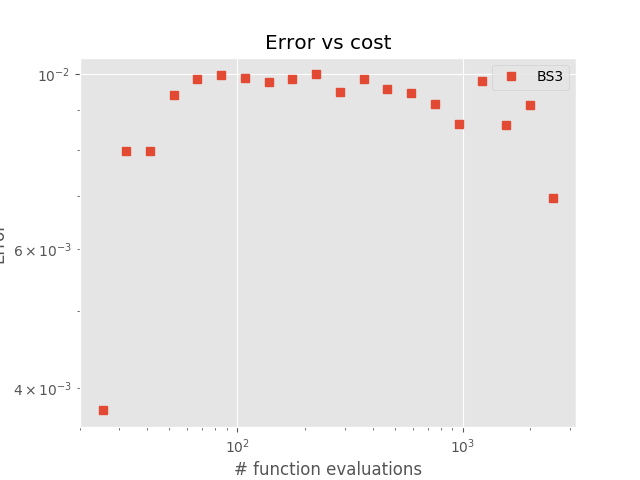

In [26]:
def mms_error(h, rk_butcher):
    hist = ode_rkexplicit(test.f, u0, tfinal=20, h=h)
    errors = numpy.array([err for t,u,err in hist])
    return numpy.linalg.norm(errors, numpy.inf)


hs = numpy.logspace(-1.5, .5, 20)
error_bs3 = [mms_error(h, rk_butcher_bs3) for h in hs]

pyplot.figure()
pyplot.loglog(20*4/hs, error_bs3, 's', label='BS3')
pyplot.title('Error vs cost')
pyplot.ylabel('Error')
pyplot.xlabel('# function evaluations')
pyplot.legend(loc='upper right');